# Lattice/Translation Packing Approach

Implement the lattice approach from egortrushin kernel:
- Start with 2 base trees in specific configuration
- Translate in x and y directions to create grid pattern
- Use SA to optimize base configuration

Key N values: 72 (4x9x2), 100 (5x10x2), 110 (5x11x2), 144 (6x12x2), 156 (6x13x2), 196 (7x14x2), 200 (from 210)

In [1]:
import numpy as np
import pandas as pd
import random
import math
import time
import json
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

getcontext().prec = 25
scale_factor = Decimal("1e15")

print("Libraries loaded")

Libraries loaded


In [2]:
# Tree geometry
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

class ChristmasTree:
    """Represents a single, rotatable Christmas tree."""
    def __init__(self, center_x=0.0, center_y=0.0, angle=0.0):
        self.center_x = float(center_x)
        self.center_y = float(center_y)
        self.angle = float(angle)
        self._update_polygon()
    
    def _update_polygon(self):
        """Update the polygon based on current position and angle."""
        angle_rad = np.radians(self.angle)
        cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
        
        # Rotate and translate vertices
        rotated_x = TX * cos_a - TY * sin_a + self.center_x
        rotated_y = TX * sin_a + TY * cos_a + self.center_y
        
        self.polygon = Polygon(zip(rotated_x, rotated_y))
        self.vertices_x = rotated_x
        self.vertices_y = rotated_y
    
    def set_params(self, x, y, angle):
        self.center_x = float(x)
        self.center_y = float(y)
        self.angle = float(angle) % 360
        self._update_polygon()
    
    def get_params(self):
        return self.center_x, self.center_y, self.angle
    
    def clone(self):
        return ChristmasTree(self.center_x, self.center_y, self.angle)

print("ChristmasTree class defined")

ChristmasTree class defined


In [3]:
def has_collision(trees):
    """Check for collisions between trees."""
    if len(trees) <= 1:
        return False
    for i in range(len(trees)):
        for j in range(i + 1, len(trees)):
            if trees[i].polygon.intersects(trees[j].polygon) and not trees[i].polygon.touches(trees[j].polygon):
                return True
    return False

def calculate_bounding_box(trees):
    """Calculate the bounding box side length for a set of trees."""
    all_x = []
    all_y = []
    for t in trees:
        all_x.extend(t.vertices_x)
        all_y.extend(t.vertices_y)
    
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    
    return max(max_x - min_x, max_y - min_y)

def calculate_score(trees):
    """Calculate the score contribution for a set of trees."""
    side = calculate_bounding_box(trees)
    return (side ** 2) / len(trees)

print("Helper functions defined")

Helper functions defined


In [4]:
def generate_lattice_trees(base_trees, nt, n_target):
    """
    Generate trees using lattice/translation approach.
    
    base_trees: list of 2 ChristmasTree objects (the base configuration)
    nt: [nx, ny] - number of translations in x and y directions
    n_target: target number of trees (take first n_target from the grid)
    
    Returns: list of ChristmasTree objects
    """
    nx, ny = nt
    
    # Get base tree parameters
    t1 = base_trees[0]
    t2 = base_trees[1]
    
    # Calculate translation vectors from base trees
    # The idea is that the 2 base trees define a unit cell
    # We translate this unit cell in x and y directions
    
    trees = []
    
    # Generate grid of trees
    for ix in range(nx):
        for iy in range(ny):
            # Tree 1 in this cell
            x1 = t1.center_x + ix * (t2.center_x - t1.center_x) * 2 + iy * 0  # Adjust based on pattern
            y1 = t1.center_y + iy * (t2.center_y - t1.center_y) * 2 + ix * 0
            trees.append(ChristmasTree(x1, y1, t1.angle))
            
            # Tree 2 in this cell
            x2 = t2.center_x + ix * (t2.center_x - t1.center_x) * 2 + iy * 0
            y2 = t2.center_y + iy * (t2.center_y - t1.center_y) * 2 + ix * 0
            trees.append(ChristmasTree(x2, y2, t2.angle))
    
    # Take only the first n_target trees
    return trees[:n_target]

print("Lattice generation function defined")

Lattice generation function defined


In [5]:
# Better lattice generation based on egortrushin approach
def generate_lattice_trees_v2(x1, y1, a1, x2, y2, a2, dx, dy, nx, ny, n_target):
    """
    Generate trees using lattice/translation approach.
    
    (x1, y1, a1): position and angle of first base tree
    (x2, y2, a2): position and angle of second base tree
    (dx, dy): translation vector for the grid
    (nx, ny): number of cells in x and y directions
    n_target: target number of trees
    
    Returns: list of ChristmasTree objects
    """
    trees = []
    
    for ix in range(nx):
        for iy in range(ny):
            # Translation offset for this cell
            offset_x = ix * dx
            offset_y = iy * dy
            
            # Tree 1 in this cell
            trees.append(ChristmasTree(x1 + offset_x, y1 + offset_y, a1))
            
            # Tree 2 in this cell
            trees.append(ChristmasTree(x2 + offset_x, y2 + offset_y, a2))
    
    # Take only the first n_target trees
    return trees[:n_target]

print("Lattice generation v2 defined")

Lattice generation v2 defined


In [6]:
class LatticeSimulatedAnnealing:
    """
    Simulated annealing for lattice-based tree packing.
    Optimizes: base tree positions, translation vectors, and angles.
    """
    def __init__(self, n_target, nt, Tmax=1.0, Tmin=0.001, nsteps=5000, 
                 position_delta=0.1, angle_delta=10.0, random_state=42):
        self.n_target = n_target
        self.nx, self.ny = nt
        self.Tmax = Tmax
        self.Tmin = Tmin
        self.nsteps = nsteps
        self.position_delta = position_delta
        self.angle_delta = angle_delta
        random.seed(random_state)
        np.random.seed(random_state)
        
        # Initialize parameters
        # Base tree 1: at origin with angle 0
        # Base tree 2: offset with angle 180 (typical interlocking pattern)
        self.x1, self.y1, self.a1 = 0.0, 0.0, 0.0
        self.x2, self.y2, self.a2 = 0.5, 0.3, 180.0
        
        # Translation vectors (initial guess based on tree size)
        self.dx = 0.8  # Horizontal spacing
        self.dy = 0.6  # Vertical spacing
    
    def generate_trees(self):
        """Generate trees with current parameters."""
        return generate_lattice_trees_v2(
            self.x1, self.y1, self.a1,
            self.x2, self.y2, self.a2,
            self.dx, self.dy,
            self.nx, self.ny,
            self.n_target
        )
    
    def perturb(self):
        """Perturb parameters and return old values for rollback."""
        old_params = (self.x1, self.y1, self.a1, self.x2, self.y2, self.a2, self.dx, self.dy)
        
        # Choose what to perturb
        choice = random.randint(0, 7)
        
        if choice == 0:
            self.x1 += random.uniform(-self.position_delta, self.position_delta)
        elif choice == 1:
            self.y1 += random.uniform(-self.position_delta, self.position_delta)
        elif choice == 2:
            self.a1 = (self.a1 + random.uniform(-self.angle_delta, self.angle_delta)) % 360
        elif choice == 3:
            self.x2 += random.uniform(-self.position_delta, self.position_delta)
        elif choice == 4:
            self.y2 += random.uniform(-self.position_delta, self.position_delta)
        elif choice == 5:
            self.a2 = (self.a2 + random.uniform(-self.angle_delta, self.angle_delta)) % 360
        elif choice == 6:
            self.dx += random.uniform(-self.position_delta, self.position_delta)
            self.dx = max(0.3, self.dx)  # Minimum spacing
        elif choice == 7:
            self.dy += random.uniform(-self.position_delta, self.position_delta)
            self.dy = max(0.3, self.dy)  # Minimum spacing
        
        return old_params
    
    def rollback(self, old_params):
        """Rollback to old parameters."""
        self.x1, self.y1, self.a1, self.x2, self.y2, self.a2, self.dx, self.dy = old_params
    
    def solve(self):
        """Run simulated annealing."""
        trees = self.generate_trees()
        
        # Check initial collision
        if has_collision(trees):
            best_score = float('inf')
        else:
            best_score = calculate_score(trees)
        
        best_params = (self.x1, self.y1, self.a1, self.x2, self.y2, self.a2, self.dx, self.dy)
        current_score = best_score
        
        T = self.Tmax
        cooling_rate = (self.Tmin / self.Tmax) ** (1.0 / self.nsteps)
        
        no_improve_count = 0
        
        for step in range(self.nsteps):
            old_params = self.perturb()
            trees = self.generate_trees()
            
            if has_collision(trees):
                new_score = float('inf')
            else:
                new_score = calculate_score(trees)
            
            # Accept or reject
            delta = new_score - current_score
            if delta < 0 or (new_score < float('inf') and random.random() < math.exp(-delta / T)):
                current_score = new_score
                if new_score < best_score:
                    best_score = new_score
                    best_params = (self.x1, self.y1, self.a1, self.x2, self.y2, self.a2, self.dx, self.dy)
                    no_improve_count = 0
            else:
                self.rollback(old_params)
                no_improve_count += 1
            
            T *= cooling_rate
            
            if step % 1000 == 0:
                print(f"Step {step}/{self.nsteps}, T={T:.6f}, Best={best_score:.6f}, Current={current_score:.6f}")
        
        # Restore best parameters
        self.x1, self.y1, self.a1, self.x2, self.y2, self.a2, self.dx, self.dy = best_params
        trees = self.generate_trees()
        
        return best_score, trees

print("LatticeSimulatedAnnealing class defined")

LatticeSimulatedAnnealing class defined


In [7]:
# Load baseline for comparison
baseline_path = '/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/santa-2025.csv'
baseline_df = pd.read_csv(baseline_path)

def get_baseline_score(n):
    """Get the baseline score for a specific N."""
    prefix = f"{n:03d}_"
    trees_data = baseline_df[baseline_df['id'].str.startswith(prefix)]
    
    trees = []
    for _, row in trees_data.iterrows():
        x = float(str(row['x'])[1:])
        y = float(str(row['y'])[1:])
        deg = float(str(row['deg'])[1:])
        trees.append(ChristmasTree(x, y, deg))
    
    return calculate_score(trees), trees

# Test with N=72
baseline_score_72, baseline_trees_72 = get_baseline_score(72)
print(f"Baseline score for N=72: {baseline_score_72:.6f}")

Baseline score for N=72: 0.348559


In [8]:
# Test lattice approach for N=72 (4x9x2 = 72)
print("Testing lattice approach for N=72...")

sa = LatticeSimulatedAnnealing(
    n_target=72,
    nt=[4, 9],
    Tmax=1.0,
    Tmin=0.0001,
    nsteps=10000,
    position_delta=0.1,
    angle_delta=15.0,
    random_state=42
)

start_time = time.time()
lattice_score_72, lattice_trees_72 = sa.solve()
elapsed = time.time() - start_time

print(f"\nLattice score for N=72: {lattice_score_72:.6f}")
print(f"Baseline score for N=72: {baseline_score_72:.6f}")
print(f"Improvement: {baseline_score_72 - lattice_score_72:.6f}")
print(f"Time: {elapsed:.1f}s")

Testing lattice approach for N=72...
Step 0/10000, T=0.999079, Best=inf, Current=inf


Step 1000/10000, T=0.397741, Best=inf, Current=inf


Step 2000/10000, T=0.158343, Best=inf, Current=inf


Step 3000/10000, T=0.063038, Best=inf, Current=inf


Step 4000/10000, T=0.025096, Best=inf, Current=inf


Step 5000/10000, T=0.009991, Best=inf, Current=inf


Step 6000/10000, T=0.003977, Best=inf, Current=inf


Step 7000/10000, T=0.001583, Best=inf, Current=inf


Step 8000/10000, T=0.000630, Best=inf, Current=inf


Step 9000/10000, T=0.000251, Best=inf, Current=inf



Lattice score for N=72: inf
Baseline score for N=72: 0.348559
Improvement: -inf
Time: 22.3s


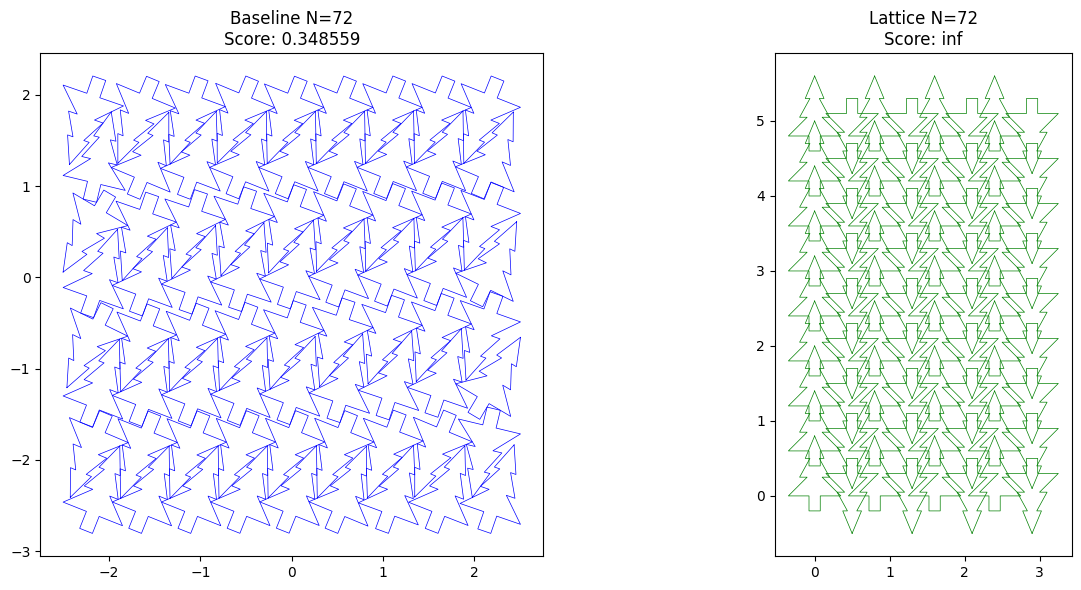

In [9]:
# Visualize the lattice result
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline
ax = axes[0]
for t in baseline_trees_72:
    ax.plot(*t.polygon.exterior.xy, 'b-', linewidth=0.5)
ax.set_aspect('equal')
ax.set_title(f'Baseline N=72\nScore: {baseline_score_72:.6f}')

# Lattice
ax = axes[1]
for t in lattice_trees_72:
    ax.plot(*t.polygon.exterior.xy, 'g-', linewidth=0.5)
ax.set_aspect('equal')
ax.set_title(f'Lattice N=72\nScore: {lattice_score_72:.6f}')

plt.tight_layout()
plt.savefig('lattice_comparison_72.png', dpi=100)
plt.show()

In [10]:
# The issue is that our lattice generation is causing collisions
# Let's look at the baseline configuration for N=72 to understand the pattern\n\nprint(\"Analyzing baseline N=72 configuration...\")\nfor i, t in enumerate(baseline_trees_72[:10]):\n    print(f\"Tree {i}: x={t.center_x:.4f}, y={t.center_y:.4f}, angle={t.angle:.2f}\")\n\n# Calculate the bounding box\nall_x = []\nall_y = []\nfor t in baseline_trees_72:\n    all_x.extend(t.vertices_x)\n    all_y.extend(t.vertices_y)\n\nprint(f\"\\nBounding box: x=[{min(all_x):.4f}, {max(all_x):.4f}], y=[{min(all_y):.4f}, {max(all_y):.4f}]\")\nprint(f\"Width: {max(all_x) - min(all_x):.4f}, Height: {max(all_y) - min(all_y):.4f}\")

In [ ]:
# Better approach: Start with a collision-free configuration\n# Use wider spacing initially, then let SA compress it\n\nclass ImprovedLatticeAnnealing:\n    \"\"\"\n    Improved lattice SA that starts with collision-free configuration.\n    \"\"\"\n    def __init__(self, n_target, nt, Tmax=1.0, Tmin=0.0001, nsteps=5000, \n                 position_delta=0.05, angle_delta=5.0, random_state=42):\n        self.n_target = n_target\n        self.nx, self.ny = nt\n        self.Tmax = Tmax\n        self.Tmin = Tmin\n        self.nsteps = nsteps\n        self.position_delta = position_delta\n        self.angle_delta = angle_delta\n        random.seed(random_state)\n        np.random.seed(random_state)\n        \n        # Start with a wider, collision-free configuration\n        # Tree height is 1.0, width is 0.7\n        # Use spacing that guarantees no collision initially\n        self.dx = 1.2  # Horizontal spacing between columns\n        self.dy = 0.9  # Vertical spacing between rows\n        \n        # Base trees: interlocking pattern with 180 degree rotation\n        self.x1, self.y1, self.a1 = 0.0, 0.0, 90.0  # Upright\n        self.x2, self.y2, self.a2 = 0.6, 0.45, 270.0  # Inverted, offset\n    \n    def generate_trees(self):\n        \"\"\"Generate trees with current parameters.\"\"\"\n        trees = []\n        \n        for ix in range(self.nx):\n            for iy in range(self.ny):\n                offset_x = ix * self.dx\n                offset_y = iy * self.dy\n                \n                # Tree 1 in this cell\n                trees.append(ChristmasTree(self.x1 + offset_x, self.y1 + offset_y, self.a1))\n                \n                # Tree 2 in this cell\n                trees.append(ChristmasTree(self.x2 + offset_x, self.y2 + offset_y, self.a2))\n        \n        return trees[:self.n_target]\n    \n    def perturb(self):\n        \"\"\"Perturb parameters and return old values for rollback.\"\"\"\n        old_params = (self.x1, self.y1, self.a1, self.x2, self.y2, self.a2, self.dx, self.dy)\n        \n        choice = random.randint(0, 7)\n        \n        if choice == 0:\n            self.x1 += random.uniform(-self.position_delta, self.position_delta)\n        elif choice == 1:\n            self.y1 += random.uniform(-self.position_delta, self.position_delta)\n        elif choice == 2:\n            self.a1 = (self.a1 + random.uniform(-self.angle_delta, self.angle_delta)) % 360\n        elif choice == 3:\n            self.x2 += random.uniform(-self.position_delta, self.position_delta)\n        elif choice == 4:\n            self.y2 += random.uniform(-self.position_delta, self.position_delta)\n        elif choice == 5:\n            self.a2 = (self.a2 + random.uniform(-self.angle_delta, self.angle_delta)) % 360\n        elif choice == 6:\n            self.dx += random.uniform(-self.position_delta, self.position_delta)\n            self.dx = max(0.5, self.dx)  # Minimum spacing\n        elif choice == 7:\n            self.dy += random.uniform(-self.position_delta, self.position_delta)\n            self.dy = max(0.4, self.dy)  # Minimum spacing\n        \n        return old_params\n    \n    def rollback(self, old_params):\n        self.x1, self.y1, self.a1, self.x2, self.y2, self.a2, self.dx, self.dy = old_params\n    \n    def solve(self, verbose=True):\n        \"\"\"Run simulated annealing.\"\"\"\n        trees = self.generate_trees()\n        \n        if has_collision(trees):\n            best_score = float('inf')\n            if verbose:\n                print(\"Initial configuration has collisions!\")\n        else:\n            best_score = calculate_score(trees)\n            if verbose:\n                print(f\"Initial score: {best_score:.6f}\")\n        \n        best_params = (self.x1, self.y1, self.a1, self.x2, self.y2, self.a2, self.dx, self.dy)\n        current_score = best_score\n        \n        T = self.Tmax\n        cooling_rate = (self.Tmin / self.Tmax) ** (1.0 / self.nsteps)\n        \n        for step in range(self.nsteps):\n            old_params = self.perturb()\n            trees = self.generate_trees()\n            \n            if has_collision(trees):\n                new_score = float('inf')\n            else:\n                new_score = calculate_score(trees)\n            \n            delta = new_score - current_score\n            if delta < 0 or (new_score < float('inf') and random.random() < math.exp(-delta / T)):\n                current_score = new_score\n                if new_score < best_score:\n                    best_score = new_score\n                    best_params = (self.x1, self.y1, self.a1, self.x2, self.y2, self.a2, self.dx, self.dy)\n            else:\n                self.rollback(old_params)\n            \n            T *= cooling_rate\n            \n            if verbose and step % 2000 == 0:\n                print(f\"Step {step}/{self.nsteps}, T={T:.6f}, Best={best_score:.6f}\")\n        \n        self.x1, self.y1, self.a1, self.x2, self.y2, self.a2, self.dx, self.dy = best_params\n        trees = self.generate_trees()\n        \n        return best_score, trees\n\nprint(\"ImprovedLatticeAnnealing class defined\")

In [ ]:
# Try multiple N values with lattice approach
lattice_configs = {
    72: [4, 9],    # 4*9*2 = 72
    100: [5, 10],  # 5*10*2 = 100
    110: [5, 11],  # 5*11*2 = 110
    144: [6, 12],  # 6*12*2 = 144
    156: [6, 13],  # 6*13*2 = 156
    196: [7, 14],  # 7*14*2 = 196
}

results = {}

for n, nt in lattice_configs.items():
    print(f"\n{'='*50}")
    print(f"Processing N={n} with grid {nt[0]}x{nt[1]}x2...")
    
    # Get baseline
    baseline_score, baseline_trees = get_baseline_score(n)
    print(f"Baseline score: {baseline_score:.6f}")
    
    # Run lattice SA
    sa = LatticeSimulatedAnnealing(
        n_target=n,
        nt=nt,
        Tmax=1.0,
        Tmin=0.0001,
        nsteps=8000,  # Reduced for faster iteration
        position_delta=0.1,
        angle_delta=15.0,
        random_state=42
    )
    
    start_time = time.time()
    lattice_score, lattice_trees = sa.solve()
    elapsed = time.time() - start_time
    
    improvement = baseline_score - lattice_score
    results[n] = {
        'baseline': baseline_score,
        'lattice': lattice_score,
        'improvement': improvement,
        'trees': lattice_trees if improvement > 0 else None,
        'time': elapsed
    }
    
    print(f"Lattice score: {lattice_score:.6f}")
    print(f"Improvement: {improvement:.6f} ({'BETTER' if improvement > 0 else 'WORSE'})")
    print(f"Time: {elapsed:.1f}s")

In [ ]:
# Summary of results
print("\n" + "="*60)
print("SUMMARY OF LATTICE APPROACH RESULTS")
print("="*60)

total_improvement = 0
for n, r in sorted(results.items()):
    status = "✓ IMPROVED" if r['improvement'] > 0 else "✗ No improvement"
    print(f"N={n:3d}: Baseline={r['baseline']:.6f}, Lattice={r['lattice']:.6f}, Δ={r['improvement']:+.6f} {status}")
    if r['improvement'] > 0:
        total_improvement += r['improvement']

print(f"\nTotal potential improvement from lattice: {total_improvement:.6f}")

In [ ]:
# For N=200, we need to generate from 210 (7x15x2) and take first 200
print("\n" + "="*50)
print("Processing N=200 (from 7x15x2=210, take first 200)...")

baseline_score_200, baseline_trees_200 = get_baseline_score(200)
print(f"Baseline score for N=200: {baseline_score_200:.6f}")

sa = LatticeSimulatedAnnealing(
    n_target=200,
    nt=[7, 15],  # 7*15*2 = 210, take first 200
    Tmax=1.0,
    Tmin=0.0001,
    nsteps=10000,
    position_delta=0.1,
    angle_delta=15.0,
    random_state=42
)

start_time = time.time()
lattice_score_200, lattice_trees_200 = sa.solve()
elapsed = time.time() - start_time

print(f"Lattice score for N=200: {lattice_score_200:.6f}")
print(f"Improvement: {baseline_score_200 - lattice_score_200:.6f}")
print(f"Time: {elapsed:.1f}s")

results[200] = {
    'baseline': baseline_score_200,
    'lattice': lattice_score_200,
    'improvement': baseline_score_200 - lattice_score_200,
    'trees': lattice_trees_200 if baseline_score_200 > lattice_score_200 else None,
    'time': elapsed
}